## Testing outputs for FACodec

In [1]:
import sys
import librosa
import torch
import soundfile as sf
import IPython.display as IPD
from huggingface_hub import hf_hub_download

sys.path.append("/home/yash7/Amphion/")

from models.codec.ns3_codec import FACodecEncoderV2, FACodecDecoderV2, FACodecRedecoder, FACodecEncoder, FACodecDecoder

/home/yash7/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
enc = FACodecEncoder(
    ngf=32,
    up_ratios=[2, 4, 5, 5],
    out_channels=256,
)
dec = FACodecDecoder(
    in_channels=256,
    upsample_initial_channel=1024,
    ngf=32,
    up_ratios=[5, 5, 4, 2],
    vq_num_q_c=2,
    vq_num_q_p=1,
    vq_num_q_r=3,
    vq_dim=256,
    codebook_dim=8,
    codebook_size_prosody=10,
    codebook_size_content=10,
    codebook_size_residual=10,
    use_gr_x_timbre=True,
    use_gr_residual_f0=True,
    use_gr_residual_phone=True,
)
rec = FACodecRedecoder()

/home/yash7/.local/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [3]:
# Loading weights
encCkpt = hf_hub_download(
    repo_id="amphion/naturalspeech3_facodec",
    filename="ns3_facodec_encoder.bin"
)
decCkpt = hf_hub_download(
    repo_id="amphion/naturalspeech3_facodec",
    filename="ns3_facodec_decoder.bin"
)

recCkpt = hf_hub_download(
    repo_id="amphion/naturalspeech3_facodec",
    filename="ns3_facodec_redecoder.bin"
)

enc.load_state_dict(torch.load(encCkpt))
dec.load_state_dict(torch.load(decCkpt))
rec.load_state_dict(torch.load(recCkpt))

<All keys matched successfully>

In [4]:
enc.eval()
dec.eval()

FACodecDecoder(
  (quantizer): ModuleList(
    (0): ResidualVQ(
      (layers): ModuleList(
        (0): FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
    (1): ResidualVQ(
      (layers): ModuleList(
        (0-1): 2 x FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
    (2): ResidualVQ(
      (layers): ModuleList(
        (0-2): 3 x FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
  )
  (model): Sequential(
    (0): Conv1d(256, 

In [5]:
def process(audio):
    audio = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0)
    return audio

testWavPath = "/home/yash7/Amphion/custom/data/sp01/speaker01_english_nonnative_effort1_1_1.wav"
testWavPath2 = "/home/yash7/Amphion/custom/data/wTIMIT_Normal_s019/008.wav"

testWav1, sr1 = librosa.load(testWavPath, sr=16000)
testWav2, sr2 = librosa.load(testWavPath2, sr=16000)

testWav1 = process(testWav1)
testWav2 = process(testWav2)

print("testWav1 shape: ", testWav1.shape)
print("testWav2 shape: ", testWav2.shape)

testWav1 shape:  torch.Size([1, 1, 220842])
testWav2 shape:  torch.Size([1, 1, 80904])


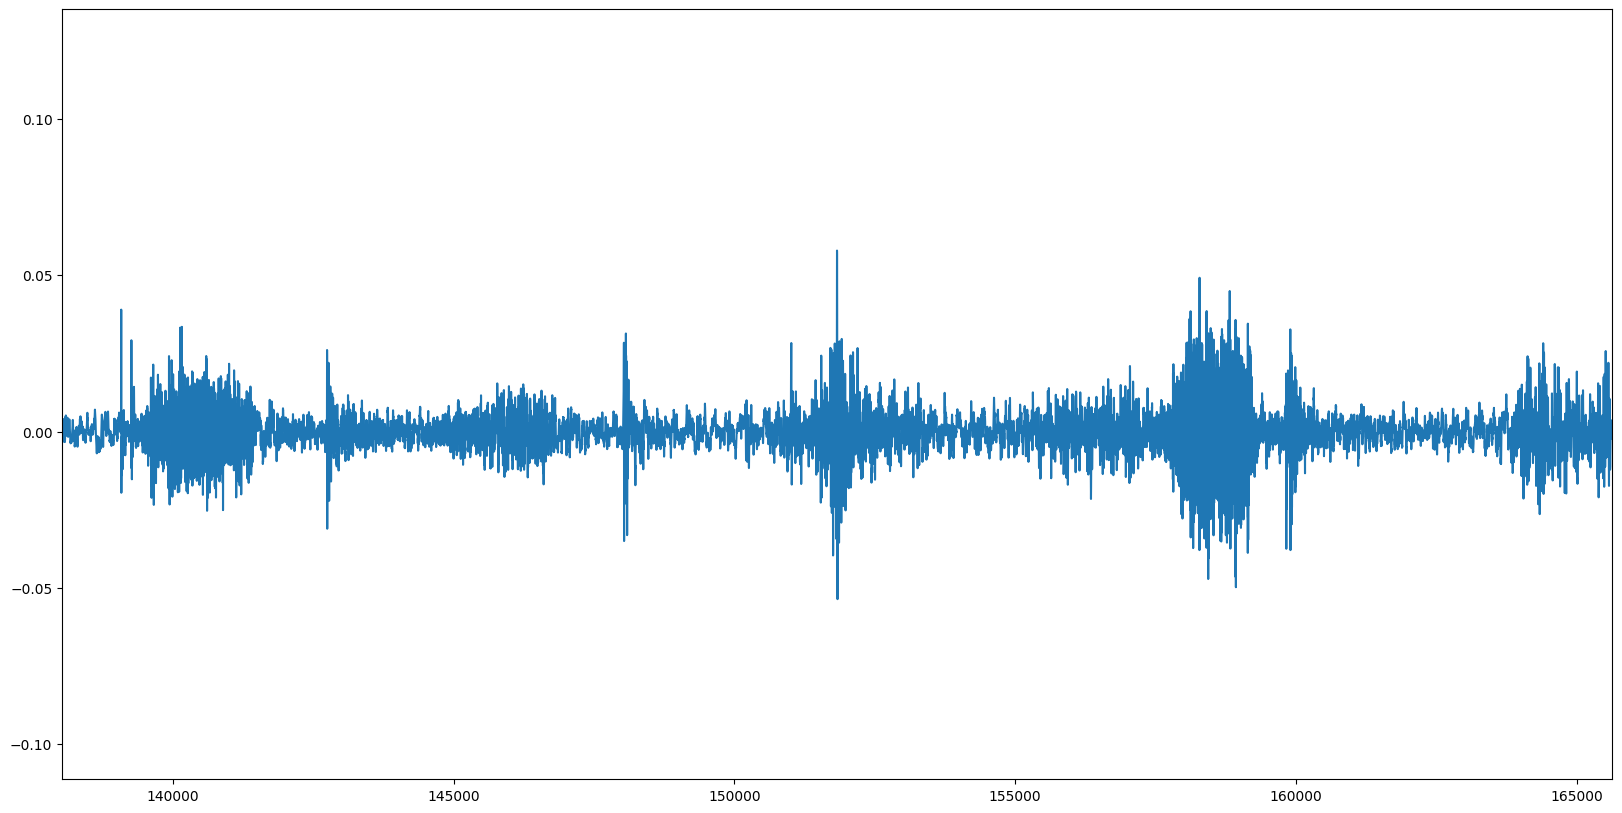

In [34]:
import matplotlib.pyplot as plt

x = [i for i in range(testWav1.size()[-1])]
plt.figure(figsize=(20, 10))
plt.plot(testWav1[0][0])
plt.xlim((5 * (testWav1.size()[-1] // 8), 6 * (testWav1.size()[-1] // 8)))
plt.show()

In [6]:
with torch.no_grad():
    encOut1 = enc(testWav1)
    print(type(dec(encOut1, eval_vq=False, vq=True)))

<class 'tuple'>


In [16]:
q1 = dec.quantizer[1].layers[0]
q2 = dec.quantizer[1].layers[1]
code = q1.codebook(torch.LongTensor([0]))
print(code.shape, code, q1)

torch.Size([1, 8]) tensor([[ 0.4598, -0.3666,  2.3507,  0.0558,  0.4972,  0.4293, -2.8407, -2.3456]],
       grad_fn=<EmbeddingBackward0>) FactorizedVectorQuantize(
  (in_proj): Linear(in_features=256, out_features=8, bias=True)
  (out_proj): Linear(in_features=8, out_features=256, bias=True)
  (_codebook): Embedding(1024, 8)
)


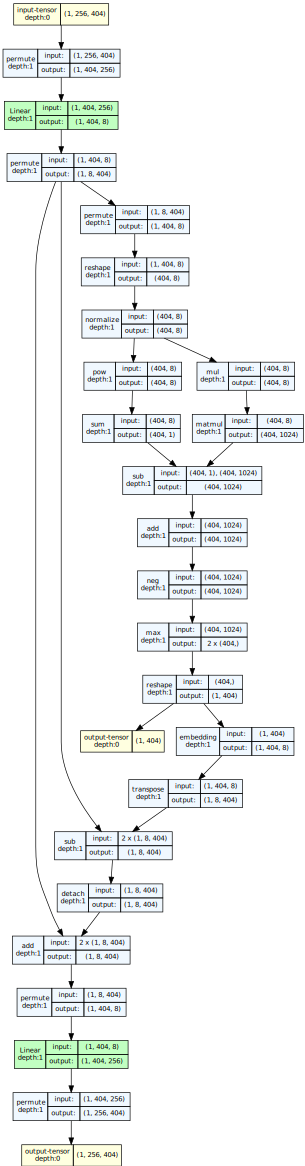

In [20]:
import torchview

modelGraph = torchview.draw_graph(q1, input_size=(1, 256, 404))
modelGraph.visual_graph

In [76]:
with torch.no_grad():
    encOut1 = enc(testWav1)
    print("encOut1 shape:\t\t\t", encOut1.shape)
    vqPostEmb1, vqId1, _, quantized1, spkEmb1 = dec(encOut1, eval_vq=False, vq=True)
    print("vqPostEmb shape:\t\t", vqPostEmb1.shape)
    
    print("VQ ID shape:\t\t\t", vqId1.shape)
    
    prosodyCode = vqId1[:1]
    print("Prosody code shape:\t\t", prosodyCode.shape)
    
    contentCode = vqId1[1:3]
    print("Content code shape:\t\t", contentCode.shape)
    
    residualCode = vqId1[3:]
    print("Residual code shape:\t\t", residualCode.shape)
    
    print("Speaker embedding shape:\t", spkEmb1.shape)
    
    reconWav = dec.inference(
        x = vqPostEmb1,
        speaker_embedding=spkEmb1
    )
    print("Reconstructed wav shape:\t", reconWav.shape)
    sf.write('recon_s019_008.wav', reconWav[0][0].cpu().numpy(), 16000)
IPD.display(IPD.Audio(testWav1[0][0], rate=16000))
IPD.display(IPD.Audio(reconWav[0][0], rate=16000))

encOut1 shape:			 torch.Size([1, 256, 1104])
vqPostEmb shape:		 torch.Size([1, 256, 1104])
VQ ID shape:			 torch.Size([6, 1, 1104])
Prosody code shape:		 torch.Size([1, 1, 1104])
Content code shape:		 torch.Size([2, 1, 1104])
Residual code shape:		 torch.Size([3, 1, 1104])
Speaker embedding shape:	 torch.Size([1, 256])
Reconstructed wav shape:	 torch.Size([1, 1, 220800])


|TensorName|Shape1|Shape2|
|---|---|---|
|wav shape:|torch.Size([1, 1, 80800])|torch.Size([1, 1, 60000])|
|encOut1 shape:|torch.Size([1, 256, 404])|torch.Size([1, 256, 300])|
|prosody enc 1 shape:|torch.Size([1, 20, 404])|torch.Size([1, 20, 300])|
|vqPostEmb shape:|torch.Size([1, 256, 404])|torch.Size([1, 256, 300])|
|VQ ID shape:|torch.Size([6, 1, 404])|torch.Size([6, 1, 300])|
|Prosody code shape:|torch.Size([1, 1, 404])|torch.Size([1, 1, 300])|
|Content code shape:|torch.Size([2, 1, 404])|torch.Size([2, 1, 300])|
|Residual code shape:|torch.Size([3, 1, 404])|torch.Size([3, 1, 300])|
|Speaker embedding shape:|torch.Size([1, 256])|torch.Size([1, 256])|
|Reconstructed wav shape:|torch.Size([1, 1, 80800])|torch.Size([1, 1, 60000])|

# Shape Observations:
|Name|Shape|Notes|
|---|---|---|
|Wav shape|(1, 1, N)|N  -> Number of samples|
|EncOut1 shape|(1, 256, N/200)|N/200 -> Number of frames, 256 -> Number of channels, 200 -> Hop Size|
|Prosody enc 1 shape|(1, 20, N/200)|N/200 -> Number of frames, 20 -> Prosody Encoding Dimension|
|vqPostEmb shape|(1, 256, N/200)|
|vqId shape|(6, 1, N/200)|6 -> Number of quantizers (prosody + content + residual)|
|Prosody code shape|(1, 1, N/200)|1 quantizer for prosody|
|Content code shape|(2, 1, N/200)|2 quantizers for content|
|Residual code shape|(3, 1, N/200)|3 quantizers for residual (acoustic details, timbre, etc)|
|Speaker Embedding shape|(1, 256)|256 -> Number of dimensions for speaker embeddings|
|Reconstructed wav shape|(1, 1, N')|Roughly the same as original wav, N' = (N / 200) * 200|

* 200 -> Hop Size
* Sample Rate = 16kHz, Hop Size = 200 => 1 frame corresponds to (200 / 16000 * 1000) = 12.5ms
* Number of quantizers (6 = 1 + 2 + 3) was a design choice. 
* Note, audio may need to be padded to an appropriate lengths otherwise the scripts may crash

## Voice Conversion

In [78]:
with torch.no_grad():
    encOut1 = enc(testWav1)
    encOut2 = enc(testWav2)
    
    vqPostEmb1, vqId1, _, quantized1, spkEmb1 = dec(encOut1, eval_vq=False, vq=True)
    vqPostEmb2, vqId2, _, quantized2, spkEmb2 = dec(encOut2, eval_vq=False, vq=True)
    
    vqPostEmb1To2 = rec.vq2emb(vqId1, spkEmb2, use_residual=False)
    reconWav1To2 = rec.inference(vqPostEmb1To2, spkEmb2)
    
    print("Shapes:")
    print("Test wav1:", testWav1.shape)
    print("Test wav2:", testWav2.shape)
    print("Recon Wav:", reconWav1To2.shape)
    
    IPD.display(IPD.Audio(testWav1[0][0], rate=16000))
    IPD.display(IPD.Audio(testWav2[0][0], rate=16000))
    IPD.display(IPD.Audio(reconWav1To2[0][0], rate=16000))

Shapes:
Test wav1: torch.Size([1, 1, 220842])
Test wav2: torch.Size([1, 1, 80904])
Recon Wav: torch.Size([1, 1, 220800])


## Extracting Content Units (Ideas):
* Use of data augmentations that do not affect content and using contrastive loss on the the samples. Some possible augmentations might include:
    * Loudness changes
    * Pitch changes
    * Addition of random White noise (maybe trying Red noise)
    * Changing Audio speed
    * Combinations of these
* Use of transcripts, audio samples and audios generated using TTS engines